# Fitting a Bayesian Neural Network to the sinc function

In this notebook, we compare a fixed-stepsize implementation of our SGHMC sampler and our extension SGHMCHD which uses hypergradient descent to adapt the stepsize online. 
We see that using arbitrary stepsizes, SGHMC can produce very bad estimates of `sinc`. SGHMCHD succesfully tunes the stepsize to a reasonable value and approaches performance of SGHMC with optimal pre-tuned stepsize.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[<tf.Variable 'neural_network_9/dense_37/kernel:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_37/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_38/kernel:0' shape=(50, 50) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_38/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_39/kernel:0' shape=(50, 50) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_39/bias:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_40/kernel:0' shape=(50, 1) dtype=float32_ref>, <tf.Variable 'neural_network_9/dense_40/bias:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'neural_network_9/append_layer_10/bias:0' shape=(1, 1) dtype=float32_ref>]
Epoch 1/1
13000/13000 [==============================] - 25s - loss: 133.6484 - mean_squared_error: 23.7312 - mean_absolute_error: 3.5134    


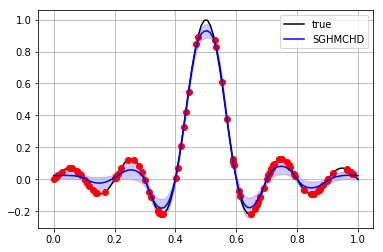

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K

from pysgmcmc.models.bayesian_neural_network import BayesianNeuralNetwork
from pysgmcmc.samplers.sghmchd import SGHMCHDSampler

import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard

from pysgmcmc.models.objective_functions import sinc
from pysgmcmc.optimizers.sghmchd import SGHMCHD
from pysgmcmc.models.bayesian_neural_network import (
    BayesianNeuralNetwork
)
from pysgmcmc.keras_utils import optimizer_name


def init_random_uniform(lower, upper, n_points, rng=None):
    if rng is None:
        rng = np.random.RandomState(np.random.randint(0, 10000))

    n_dims = lower.shape[0]

    return np.array(
        [rng.uniform(lower, upper, n_dims) for _ in range(n_points)]
    )

from keras import backend as K
optimizer = SGHMCHD

n_datapoints = 100


x_train = init_random_uniform(
    lower=np.zeros(1), upper=np.ones(1), n_points=n_datapoints
)

y_train = sinc(x_train)

x_train = x_train[:1000]
y_train = y_train[:1000]

x_test = np.linspace(0, 1, 100)[:, None]
y_test = sinc(x_test)


def fit_bnn(train_data, test_data, optimizer, optimizer_kwargs):
    x_train, y_train = train_data
    x_test, y_test = test_data

    model = BayesianNeuralNetwork(
        optimizer=optimizer, **optimizer_kwargs
    )
    model.train(x_train, y_train)

    prediction_mean, prediction_variance = model.predict(x_test)

    prediction_std = np.sqrt(prediction_variance)

    plt.grid()

    plt.plot(x_test[:, 0], y_test, label="true", color="black")
    plt.plot(x_train[:, 0], y_train, "ro")

    plt.plot(x_test[:, 0], prediction_mean, label=optimizer_name(optimizer), color="blue")
    plt.fill_between(x_test[:, 0], prediction_mean + prediction_std, prediction_mean - prediction_std, alpha=0.2, color="blue")

    plt.legend()
    plt.show()

fit_bnn(train_data=(x_train, y_train), test_data=(x_test, y_test), optimizer=SGHMCHD, optimizer_kwargs={"learning_rate": 0.000000001})

For comparison, we show how "standard" SGHMC fails given the exact same stepsize that we initialized our hyperdescent extension with.

Epoch 1/1
13000/13000 [==============================] - 17s - loss: 502.4601 - mean_squared_error: 24.7741 - mean_absolute_error: 3.7806    


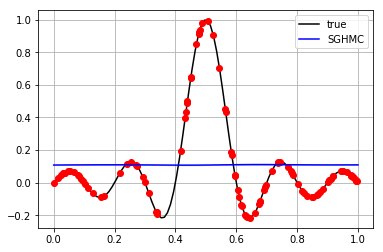

In [20]:
from pysgmcmc.optimizers.sghmc import SGHMC
fit_bnn(train_data=(x_train, y_train), test_data=(x_test, y_test), optimizer=SGHMC, optimizer_kwargs={"learning_rate": 0.000000001})

Finally, we also plot SGHMC with a tuned stepsize as an optimistic upper bound on our performance:

Epoch 1/1
13000/13000 [==============================] - 19s - loss: 23.8874 - mean_squared_error: 30.4522 - mean_absolute_error: 3.8751    


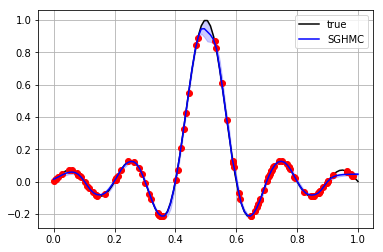

In [23]:
fit_bnn(train_data=(x_train, y_train), test_data=(x_test, y_test), optimizer=SGHMC, optimizer_kwargs={"learning_rate": 0.01})